# Revisit Logistic Regression for Binary Classification

## Initialization for Notebook

To begin with, I will use `numpy` to handle linear algebra, and `matplotlib` to handle plotting.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,                # I am assuming you have installed tex
    "font.family": "sans-serif",
    # "font.size": 12
})

# creating static figure
# %matplotlib inline

# import matplotlib as mpl
# mpl.rc("figure", dpi=150)

# creating interactive figure under Jupyter frontend
# %matplotlib notebook

# creating interactive figure under VScode (pip install ipympl)
%matplotlib widget

np.random.seed(1985)

## The Problem

Suppose the training data $(\mathbf x_i, y_i)_{i=1}^N$, where $\mathbf x_i \in \mathbb R^d$ and $y_i \in \{0, 1\}$. Given a new $\widehat{\mathbf x} \in \mathbb R^d$, what is your prediction for $\widehat{y}$?

### Oversimplified Case: $d=1$
We can start simple from $d = 1$. In this case, $\mathbf x$ can be written as $x$.

**Generate Dataset**. I want to generate a sample dataset $(x_i, y_i)_{i=1}^N$ where we first generate the labels:
$$
y_i \sim \mathcal U\{0, 1\}
$$
and then we generate 
$$
x_i \sim \mathcal N(y_i, 1)
$$

Now we are ready to generate our first fake dataset.

In [4]:
# parameters
sigma = 1
n = 50

yy = np.random.randint(2, size=(n))       # 2 is excluded, so yy is a vector of length N
xx = np.random.randn(n) * sigma + yy

# peak the first elements for both vectors.
print(xx[:5], yy[:5])

[-0.68627186  1.8564116   0.9961407   0.3483634   0.12661449] [1 1 0 0 1]


We also want to see the fake dataset like below.

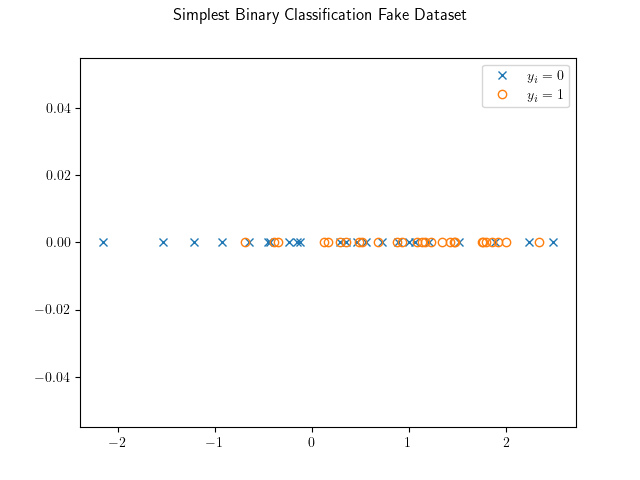

In [5]:
zz = np.zeros(n)

fig, ax = plt.subplots()
ax.plot(xx[yy==0], zz[yy==0], 'x', label='$y_i = 0$')
ax.plot(xx[yy==1], zz[yy==1], 'o', mfc='none', label='$y_i = 1$')     # mfc = markerfacecolor
ax.legend()
fig.suptitle('Simplest Binary Classification Fake Dataset')
plt.show()

### The First Model

**Intuition.** Intuitively, if the new point $\widehat{x}$ is located at $0.5$, it should be hard for a model to tell which class confidently. If a point is strongly negative, then it's more likely that this point belongs to $y_i = 0$, and $y_i=1$ for $\widehat{x}$ is strongly positive. Also, $0.5$ comes from cheating!

**The model (first stab) --- logistic regression.** The industry standard practice is try to build a classifier on this. One of the well-known idea is to come up with a sigmoid function applied on a linear model of input as a predictor
$$
h(x) = \sigma(w \cdot x + b)
$$
where $w, b \in \mathbb R^1$ are the weights and biases (a.k.a., parameters to be determined). Sigmoid function $\sigma(\cdot)$  takes the form
$$
\sigma(x) = \frac1{1+\exp(-x)}.
$$

> **About Sigmoid.** It's not memorable for me for a pretty long time, especially for the signs therein, always make me fumble. There are some observations that can probably help me recall the exact form
> - This function should have some probabilistic meaning, so the range of this function is ideally $[0, 1]$, hence the denominator should be $\ge 1$, hence the first sign should be $+$.
>   - If the function takes the form of $\frac1{1-\exp(\cdot)}$, then the range will be $[1, +\infty)$.
> - sigmoid is kind of like a CDF
>   - When $x \to -\infty$, the denominator will be $+\infty$, hence the function value will be 0.
>   - When $x \to +\infty$, the denominator will be 1, hence the function value will be 1.
> - If the denominator is $1+\exp(x)$, then the behavior will be exactly the opposite.
>   - It seems to be not a big deal? Since we still have the freedom to choose $w$ and $b$.

> - [ ] **Activation.** There are also all sorts of activation functions: ReLU, tanh, LeakyReLU, SwiGLU, just to name a few. To find more, below are more resources
> - https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
> - https://en.wikipedia.org/wiki/Activation_function
> - https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
> - https://www.tensorflow.org/api_docs/python/tf/keras/activations

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

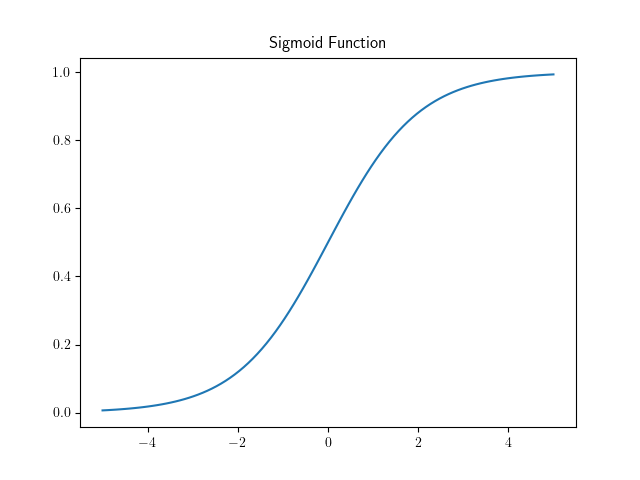

In [7]:
xx0 = np.linspace(-5, 5, 100)
yy0 = sigmoid(xx0)
plt.figure()
plt.plot(xx0, yy0)
plt.title('Sigmoid Function')
plt.show()

By setting some fake parameters on this randomly chosen model, we can have some predictions to compare with ground truth.

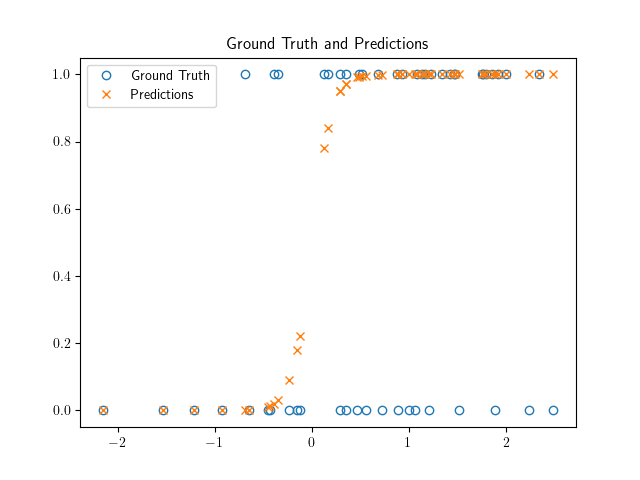

In [8]:
w = 10
b = 0
tt = sigmoid(w * xx + b)

plt.figure()
plt.plot(xx, yy, 'o', label='Ground Truth', mfc='none')
plt.plot(xx, tt, 'x', label='Predictions')
plt.legend()
plt.title('Ground Truth and Predictions')
plt.show()

Interestingly, the random model is performing reasonably well. This should be considered as pure luck. If we change the sign of $w$, then we will have something pretty off.

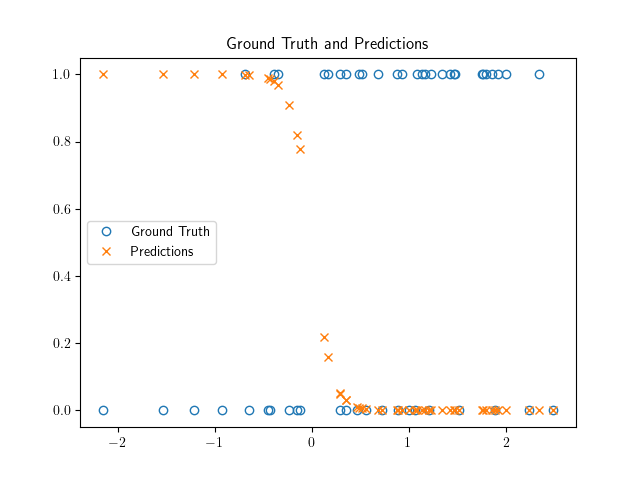

In [9]:
w = -10
b = 0
tt = sigmoid(w * xx + b)

plt.figure()
plt.plot(xx, yy, 'o', label='Ground Truth', mfc='none')
plt.plot(xx, tt, 'x', label='Predictions')
plt.legend()
plt.title('Ground Truth and Predictions')
plt.show()

This leads to the strategy of initializing parameters. Again, several options:
- Zero initialization
- Random initialization

There are some fancy initialization named by people:
- Kaiming Initialization (He Initialization) [@heDelvingDeepRectifiers2015]
- Xavier Initialization (Glorot Initialization) [@glorotUnderstandingDifficultyTraining2010]

Libraries:
- https://pytorch.org/docs/stable/nn.init.html
- https://www.tensorflow.org/api_docs/python/tf/keras/initializers

**How to determine parameters?** Once we have the model, we need to define our objective function (optimization problem). Again, there're many choices.
- Minimize loss function (sometimes interchangeable with error function, cost function)
  - Cross-entropy --- popular for probability
  - $L^2$ --- popular for regression
  - $L^1$ --- popular for sparse
- Maximize
  - Likelihood --- probability of observed data
  - A-Posterior --- posterior density of some random variable.

There are many loss functions and it can go very deep.
  - https://en.wikipedia.org/wiki/Loss_function
  - https://en.wikipedia.org/wiki/Loss_functions_for_classification
  - https://pytorch.org/docs/stable/nn.html#loss-functions

Below we took a first stab, implementing three basic ones, to begin with.

In [10]:
def ensure_2d(v):
    if len(v.shape) == 1:
        return np.expand_dims(v, axis=1)


def bceloss(p, q):
    # dim(p) = dim(q) = (n, k)
    p, q = ensure_2d(p), ensure_2d(q)
    return -np.sum(p * np.log(q) + (1-p) * np.log(1-q), axis=1)


def l2loss(y, t):
    # dim(y) = dim(t) = (n, k)
    y, t = ensure_2d(y), ensure_2d(t)
    return np.linalg.norm(y - t, axis=1)


def l1loss(y, t):
    # dim(y) = dim(t) = (n, k)
    y, t = ensure_2d(y), ensure_2d(t)
    return np.linalg.norm(y - t, 1, axis=1)

A (maybe not so common) pitfall in implementing BCE is like below
```python
def bceloss(p, q):
    p, q = ensure_2d(p), ensure_2d(q)
    return -np.sum(
        p * np.log(q), # missing the second part
        axis=1)
```
Because on Wikipedia, the formula looks like
$$
\mathcal H(p, q) = -\sum_{x\in \mathcal X} p(x) \log q(x)
$$
where $\mathcal X$ is the support. In the case of binary cross entropy, support $\mathcal X = \{0, 1\}$.
- The miss reading can happen for $\mathcal X$ being the entire dataset, while the formula above is only for one data point.
- The $x$ above is not the $x$ in our context. It's actually $y$.

There is another confusion point, for the $p$ and $q$ in the expression, which should be the prediction? which should be the ground truth?
- The answer is $p(x)$ is the ground truth, while $q(x)$ is the prediction.
- To help to remember, say we interchange those two,
  - When $q(x) \ne 0$ and $p(x) = 0$ (which is likely to happen), then the loss will be $-q(x) \cdot \log 0 = +\infty$.
- To help to remember further,
  - $\log$ and $\sigma$ somehow cancelled. (Because $\sigma$ contains $\exp$).

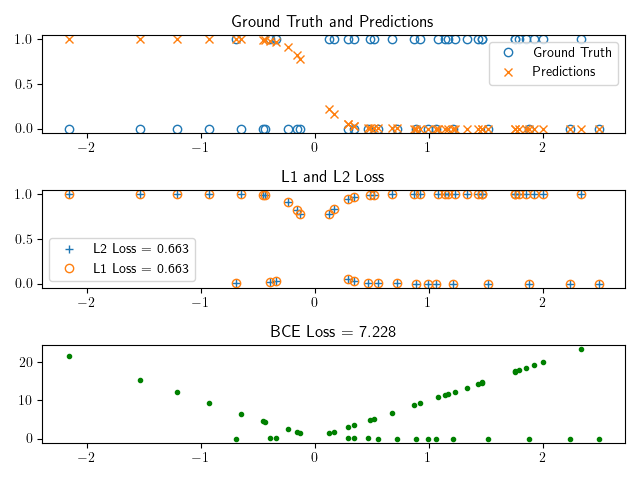

In [11]:
w = -10
b = 0
tt = sigmoid(w * xx + b)

loss_l2 = l2loss(yy, tt)
loss_l1 = l1loss(yy, tt)
loss_bce = bceloss(yy, tt)

plt.figure()
ax1 = plt.subplot(311)
ax1.plot(xx, yy, 'o', label='Ground Truth', mfc='none')
ax1.plot(xx, tt, 'x', label='Predictions')
ax1.legend()
ax1.set_title('Ground Truth and Predictions')

ax2 = plt.subplot(312)
ax2.plot(xx, loss_l2, '+', label=f'L2 Loss = {np.mean(loss_l2):.3f}')
ax2.plot(xx, loss_l1, 'o', label=f'L1 Loss = {np.mean(loss_l1):.3f}', mfc='none')
ax2.legend()
ax2.set_title('L1 and L2 Loss')

ax3 = plt.subplot(313)
ax3.plot(xx, loss_bce, 'g.')
ax3.set_title(f'BCE Loss = {np.mean(loss_bce):.3f}')

plt.tight_layout()
plt.show()

Observations:
- L1 and L2 loss is the same for $d=1$.
- L1 and L2 loss seems not penalizing the large $x$ (in absolute value) by a lot.
- BCE loss seems to penalize large $x$ in absolute value proportionally.

To simply our discussion, we choose BCE loss. Now we can use optimization algorithm to lower the loss.

Again, tons options at hand. Basic and popular ones can be
- **Gradient descent** (GD) or **batch gradient descent** (BGD) in some ML literatures.
- **Stochastic gradient descent** (SGD) sometimes refers to update the model using only one training sample at a time, sometimes refers to using multiple training samples. It also has some other names like **mini-batch gradient descent** and **online gradient descent**.
  - These algorithms are meaningful for large datasets.

There are some other variants for neural networks that are important to accelerate the training process
- Adam, AdamW, NAdam, AMSGrad, RMSProp

Below we apply SGD to our model. Recall our loss function for each data point is
$$
\begin{align*}
\mathcal L_i &= y_i \cdot \log \sigma(w\cdot x_i+b) + (1-y_i) \cdot \log (1-\sigma(w\cdot x_i+b))\\
&= y_i \cdot \log t_i + (1-y_i) \cdot \log (1-t_i)
\end{align*}
$$
The derivative w.r.t. $w$ and $b$ is then:
$$
\begin{align*}
\partial_w \mathcal L &= \frac{y_i}{t_i} \cdot \frac{\partial t_i}{\partial a_i} \cdot \frac{\partial a_i}{\partial w} + \frac{1-y_i}{1-t_i} \cdot \frac{\partial (1-t_i)}{\partial a_i} \cdot \frac{\partial a_i}{\partial w}\\
&= \frac{y_i}{t_i} \cdot t_i (1-t_i) \cdot x_i + \frac{1-y_i}{1-t_i} \cdot t_i (1-t_i) \cdot (-1) \cdot x_i\\
&= [y_i(1-t_i) - (1-y_i) t_i] x_i\\
&= (y_i - t_i) \cdot x_i
\end{align*}
$$
Similarly,

\begin{align*}
\partial_b \mathcal L &= y_i - t_i
\end{align*}

Now we start to build the algorithm updates the weights and biases. The skeleton will be like this:

```python
for epoch in range(max_epoch):
    
    for i in range(n):
        # update tt
        tt_i = sigmoid(w * xx[i] + b)

        # compute gradient contribution by x_i
        grad_w_i = (yy[i] - tt_i) * xx[i]
        grad_b_i = (yy[i] - tt_i)

        w = w + lr * grad_w_i
        b = b + lr * grad_b_i
```
The hyperparameter will be `max_epoch` and learning rate `lr`.

In [12]:
def train(xx, yy, w0, b0, max_epoch, lr):
    
    w = w0
    b = b0
    tt = sigmoid(w * xx + b)
    
    w_hist = []
    b_hist = []
    loss_hist = []
    
    for epoch in range(max_epoch):
            
        for i in range(n):
            
            tt[i] = sigmoid(w * xx[i] + b)
                        
            grad_w_i = (yy[i] - tt[i]) * xx[i]
            grad_b_i = (yy[i] - tt[i])

            w = w + lr * grad_w_i
            b = b + lr * grad_b_i
            
            loss_hist.append(np.mean(bceloss(yy, tt)))        
            w_hist.append(w)
            b_hist.append(b)
            
    return w_hist, b_hist, loss_hist


def run_train(w0, b0, max_epoch, lr):
    w_hist, b_hist, loss_hist = train(xx, yy, w0=w0, b0=b0, max_epoch=max_epoch, lr=lr)

    fig = plt.figure(figsize=(9,3))
    ax1 = fig.add_subplot(1,3,1)
    ax1.plot(w_hist)
    ax1.set_title(f'$w = {w_hist[-1]:.3f}$')
    ax1.set_xlabel('number of updates')

    ax2 = fig.add_subplot(1,3,2)
    ax2.plot(b_hist)
    ax2.set_title(f'$b = {b_hist[-1]:.3f}$')
    ax2.set_xlabel('number of updates')
    fig.suptitle(f'$w_0 = {w0:.3f}$, $b_0 = {b0:.3f}$, max_epoch = {max_epoch}, lr = {lr}')

    ax3 = fig.add_subplot(1,3,3)
    ax3.plot(loss_hist)
    ax3.set_title(f'Loss = {loss_hist[-1]:.3f}')
    ax3.set_xlabel('number of updates')
    fig.suptitle(f'$w_0 = {w0:.3f}$, $b_0 = {b0:.3f}$, max_epoch = {max_epoch}, lr = {lr}')
    
    fig.tight_layout()
    

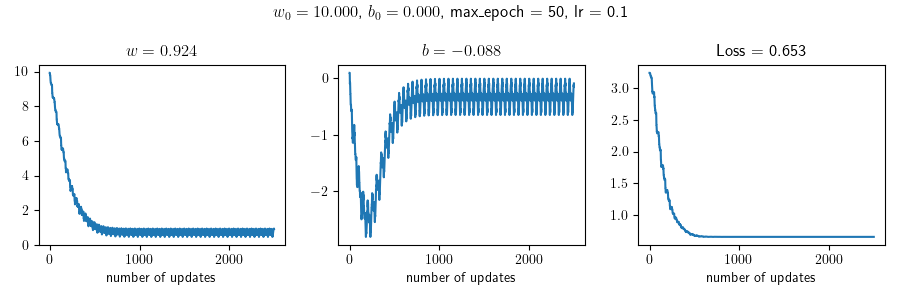

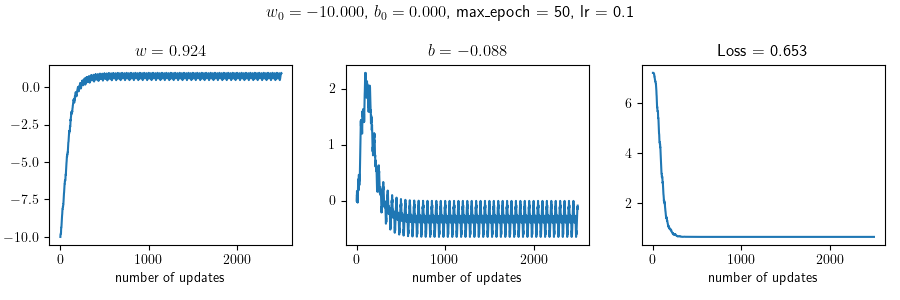

In [13]:
run_train(w0=10, b0=0, max_epoch=50, lr=0.1)
run_train(w0=-10, b0=0, max_epoch=50, lr=0.1)

It seems that with different initial value, the algorithm is converging to the same result, thanks to that the loss function is a convex function.

Let's visualize the path of SGD.

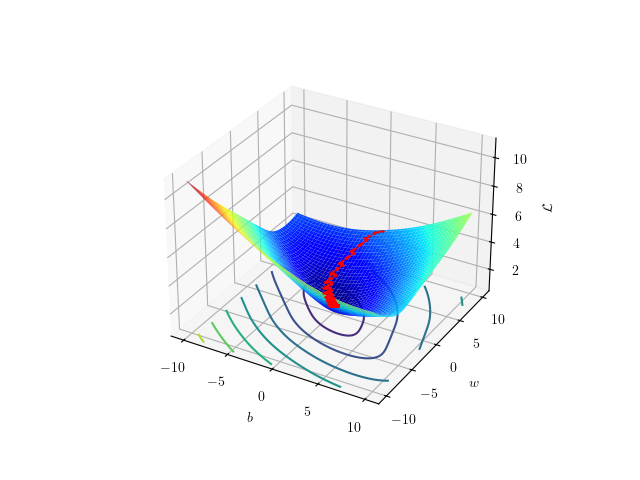

In [15]:
ww = np.linspace(-10, 10, 100)
bb = np.linspace(-10, 10, 100)

ll = np.zeros((100, 100))
for i, w in enumerate(ww):
    for j, b in enumerate(bb):
        tt = sigmoid(w * xx + b)
        ll[i, j] = np.mean(bceloss(yy, tt))
        
ww, bb = np.meshgrid(ww, bb)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(ww, bb, ll, cmap='jet')
ax.contour(ww, bb, ll, zdir='z', offset=0)

w_hist, b_hist, loss_hist = train(xx, yy, w0=10, b0=0, max_epoch=50, lr=0.1)
ax.plot(b_hist, w_hist, loss_hist, 'r.', markersize=1, zorder=10)
ax.set_xlabel('$b$')
ax.set_ylabel('$w$')
ax.set_zlabel('$\mathcal L$')
plt.show()

TODO:

- Evaluation
- Overfitting
- d > 1
- pytorch implementation